In [2]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('../../')
from utils.utils import crop_dataframes, amplitude_envelope, correlation, sine_wave, first_maximum_lag

# Myo

In [ ]:
fp = "data/2025_03_19_00_29_40_Myo_EMG_Latency/"

myo_path = "myo/emg/emg.csv"
event_path = "event_log/event_log.csv"

myo_df = pd.read_csv(os.path.join(fp, myo_path))
event_df = pd.read_csv(os.path.join(fp, event_path))

myo_sr = 200

In [4]:
waveform_start_counts = 0

for event in event_df["Event"]:
    if "Waveform Pulse Start" in event:
        waveform_start_counts += 1

print(f"{waveform_start_counts} waveform pulses found")

500 waveform pulses found


In [5]:
waveform_dict = {}
durations = np.zeros(waveform_start_counts)

for i in range(waveform_start_counts):

    # get start time for pulse
    start_time = event_df.loc[event_df["Event"] == f"Waveform Pulse Start {str(i).zfill(5)}", "Event Time"].values[0]
    end_time = event_df.loc[event_df["Event"] == f"Waveform Pulse End {str(i).zfill(5)}", "Event Time"].values[0]
    durations[i] = end_time-start_time

    # crop to pulse time plus gap to ensure whole pulse in signal and take first 2 seconds
    cropped = crop_dataframes(myo_df, start_time, end_time)
    cropped = cropped["emg3"].to_numpy()[:int(myo_sr*2)]
    cropped = cropped-np.mean(cropped)
    waveform_dict[str(i)] = cropped

print(f"Mean Pulse Duration {np.mean(durations)}")

Mean Pulse Duration 2.054502876281738


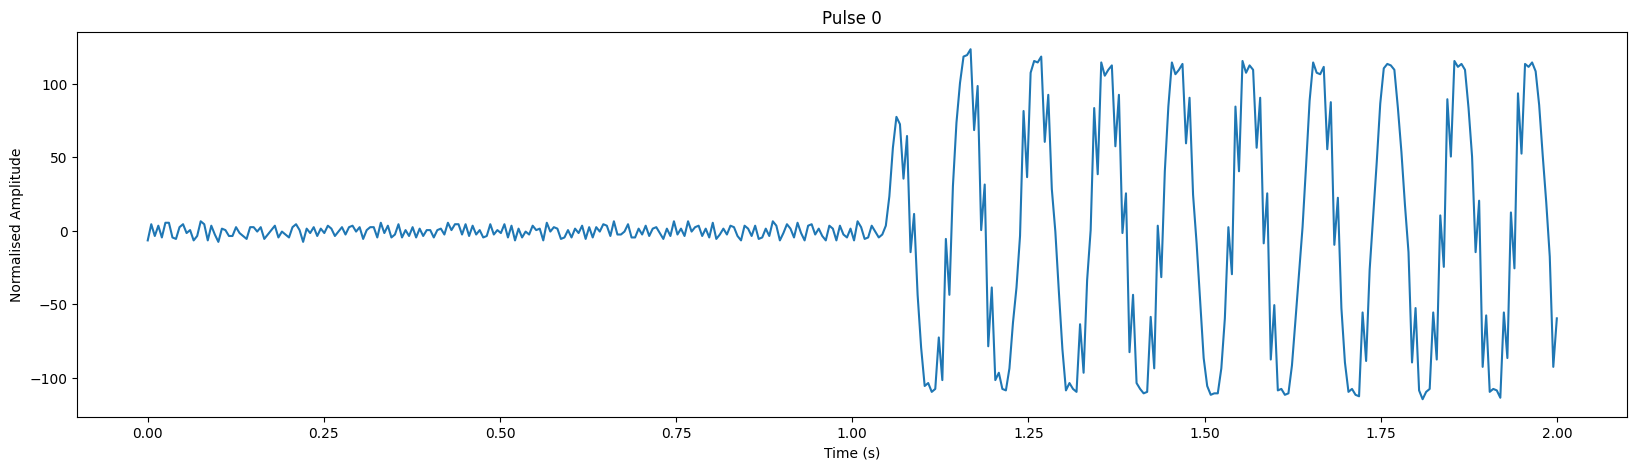

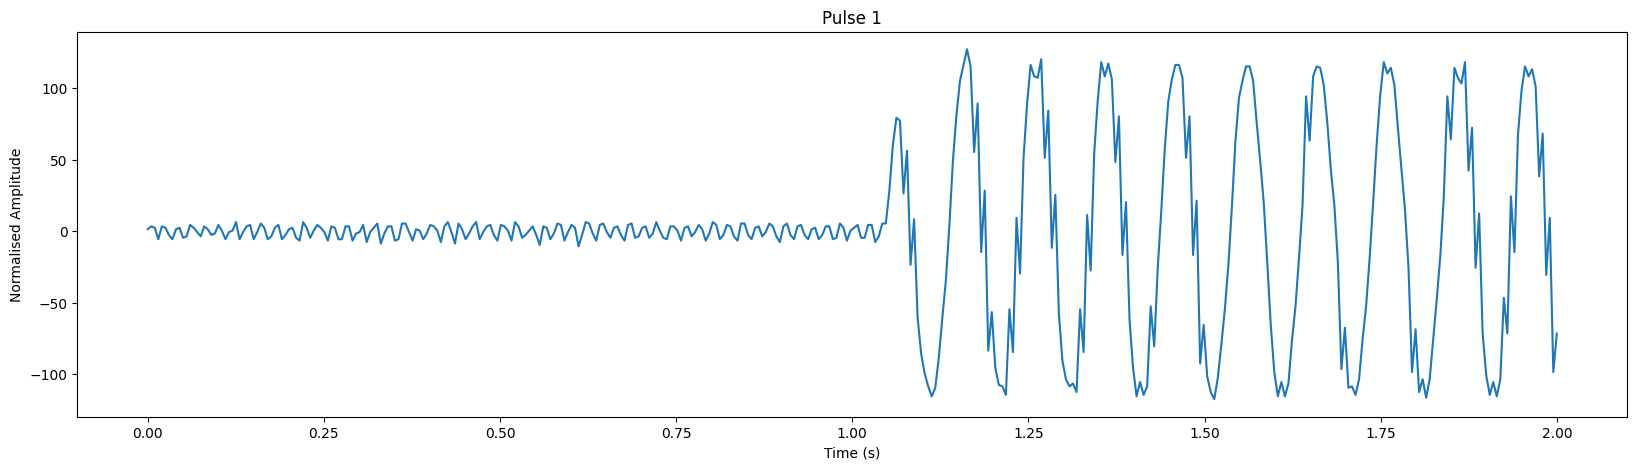

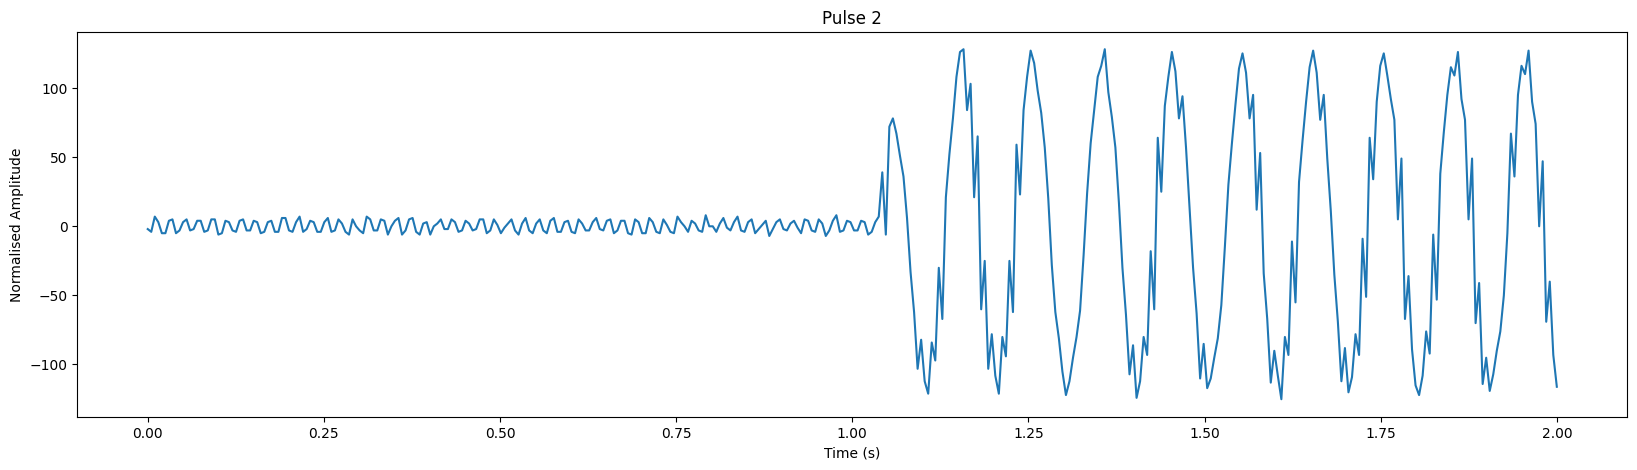

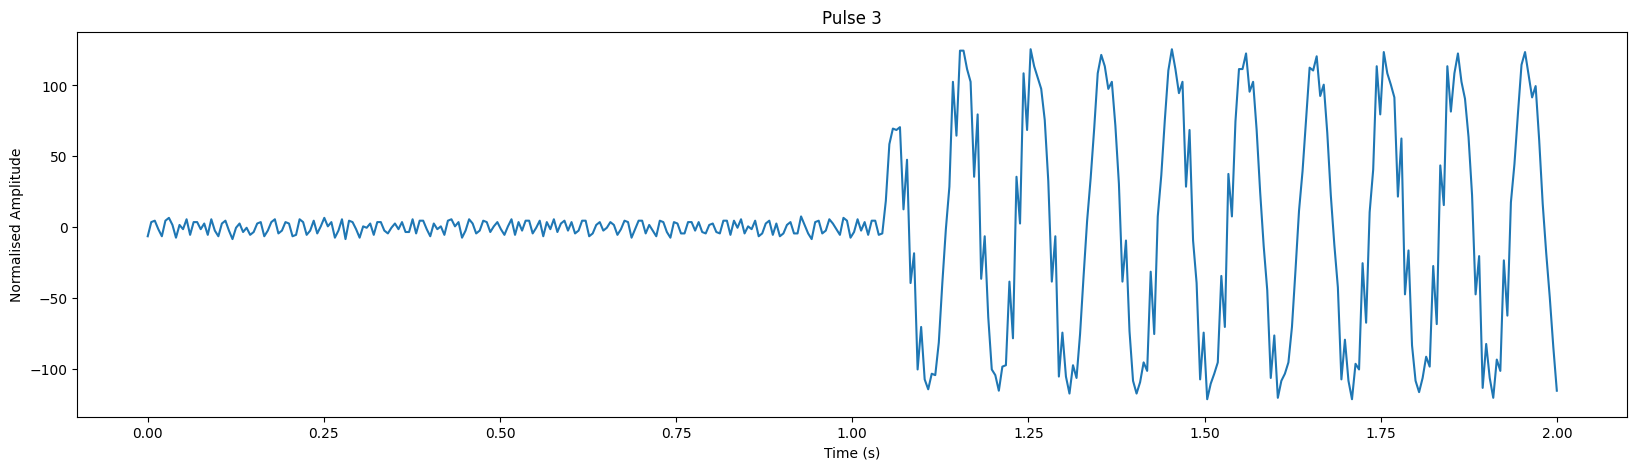

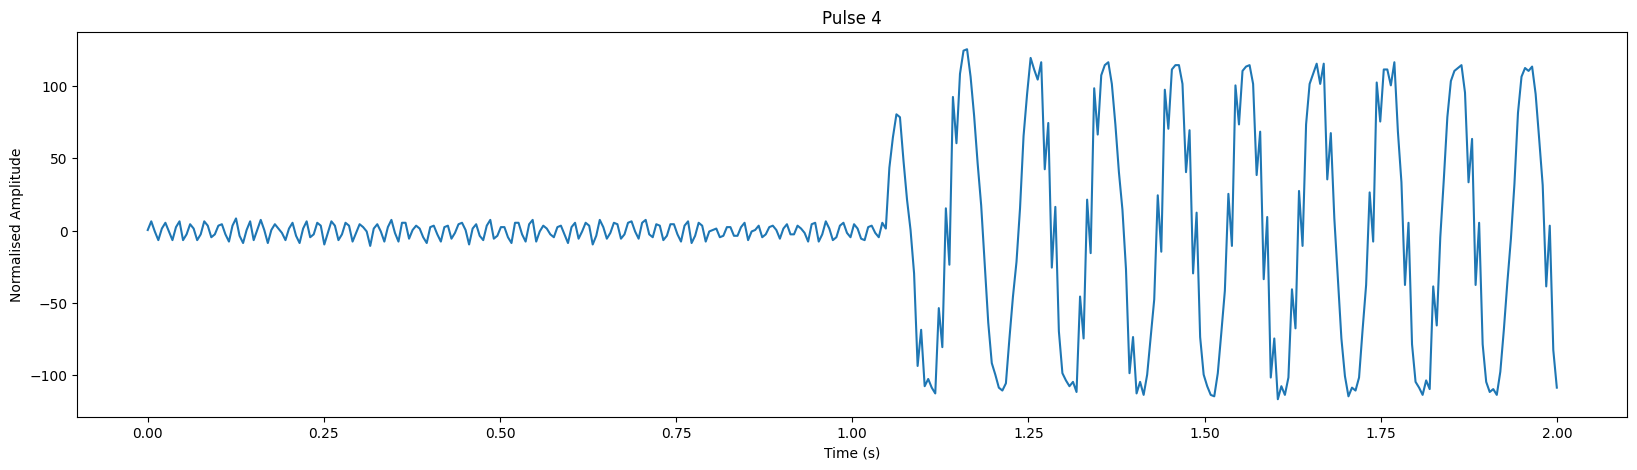

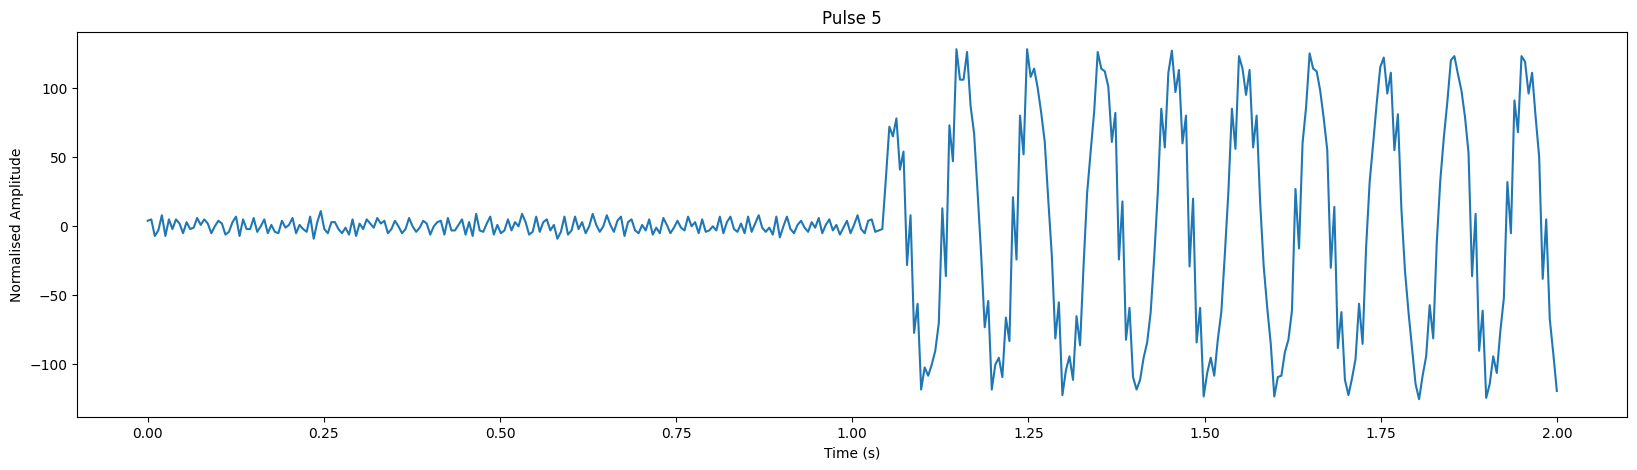

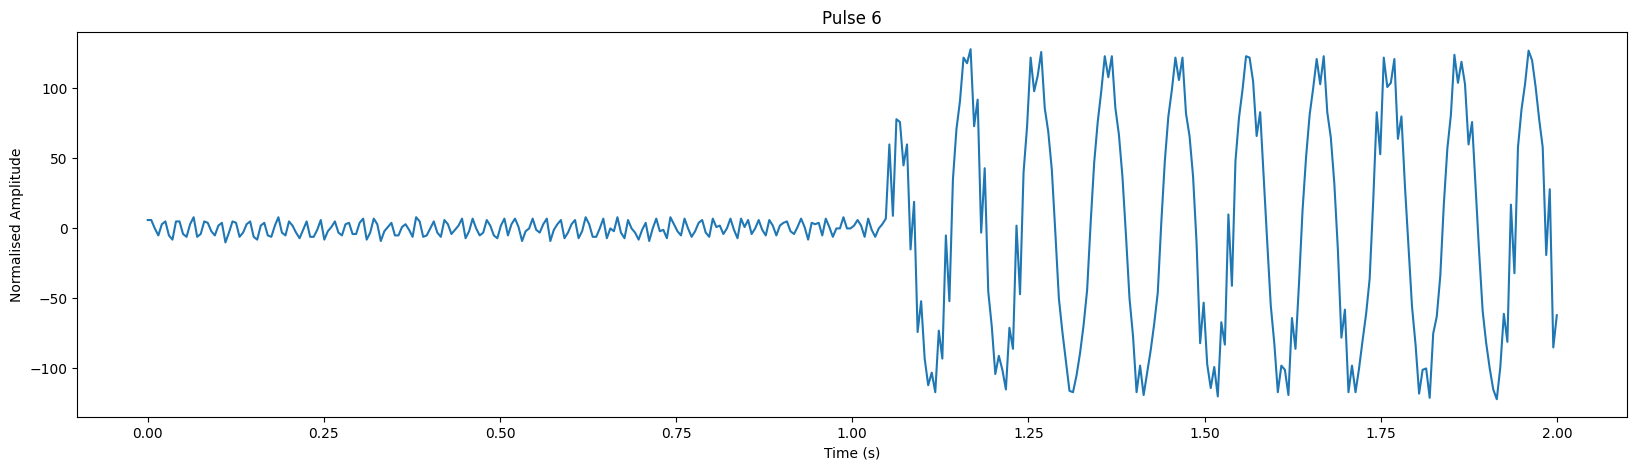

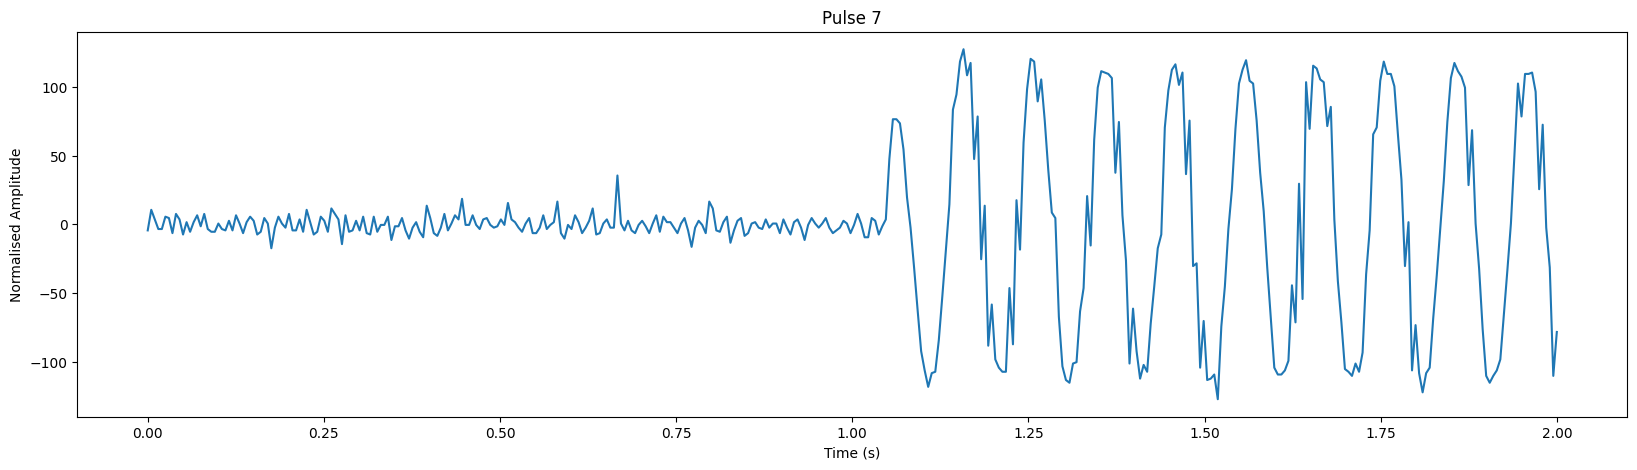

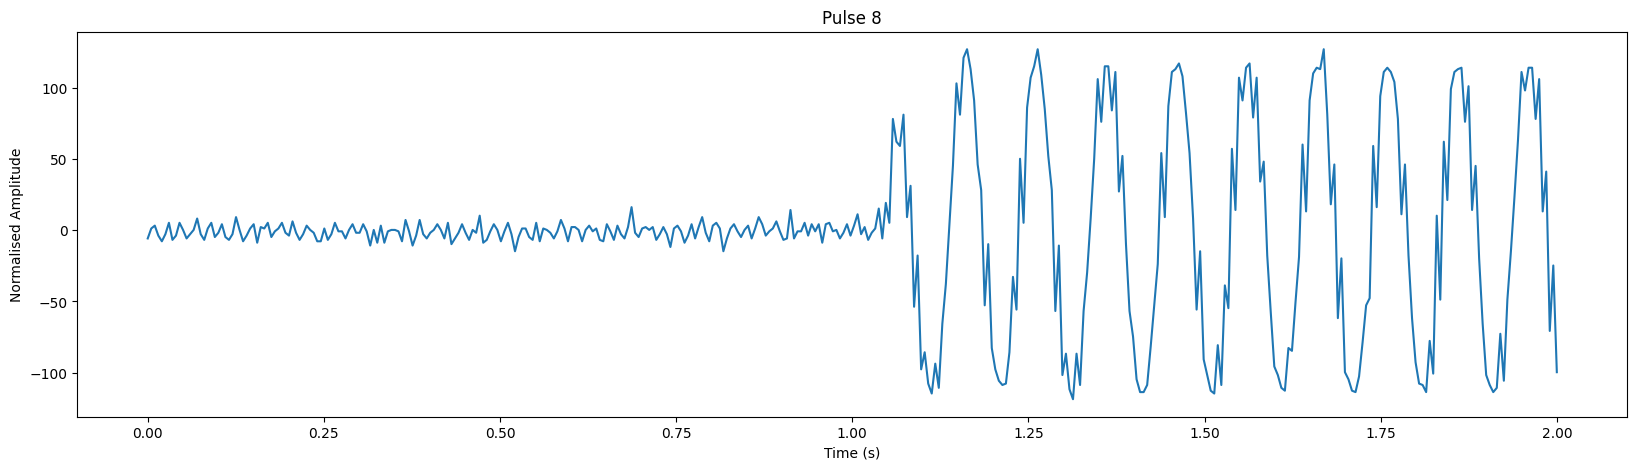

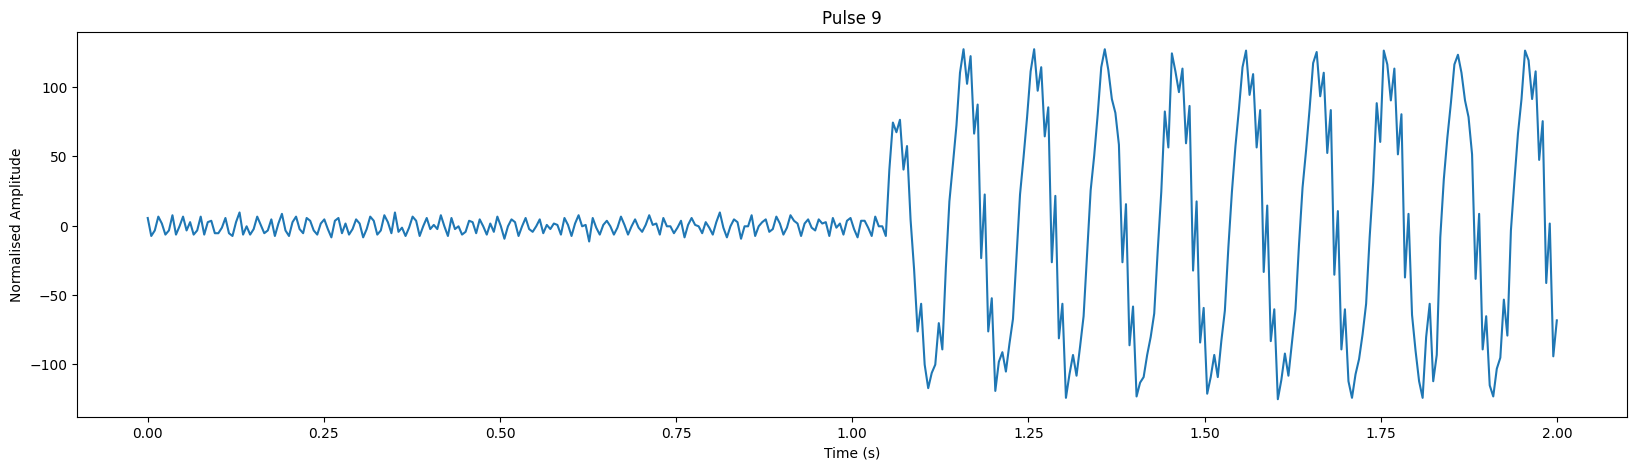

In [6]:
no_to_display = 10

for i in range(no_to_display):

    sig = waveform_dict[str(i)]
    x = np.linspace(0, 2, len(sig))

    plt.figure(figsize=(20, 5))
    plt.title(f"Pulse {i}")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalised Amplitude")
    plt.plot(x, sig)
    plt.show()

First correlation peak between EMG and generated single period: 208


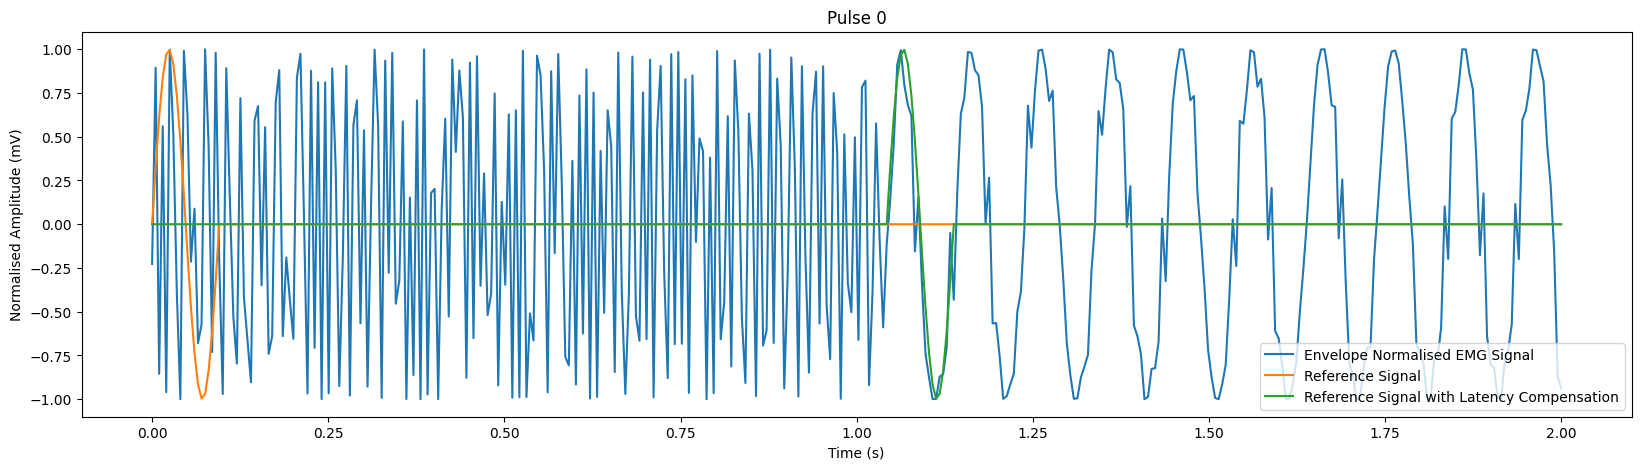

First correlation peak between EMG and generated single period: 207


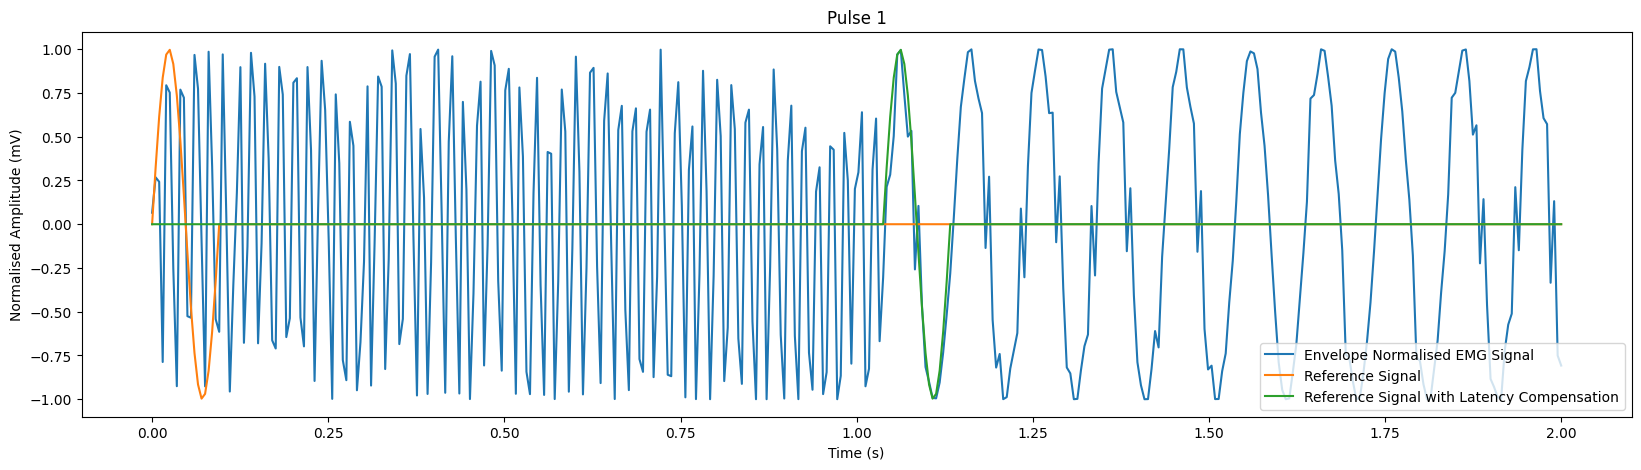

First correlation peak between EMG and generated single period: 206


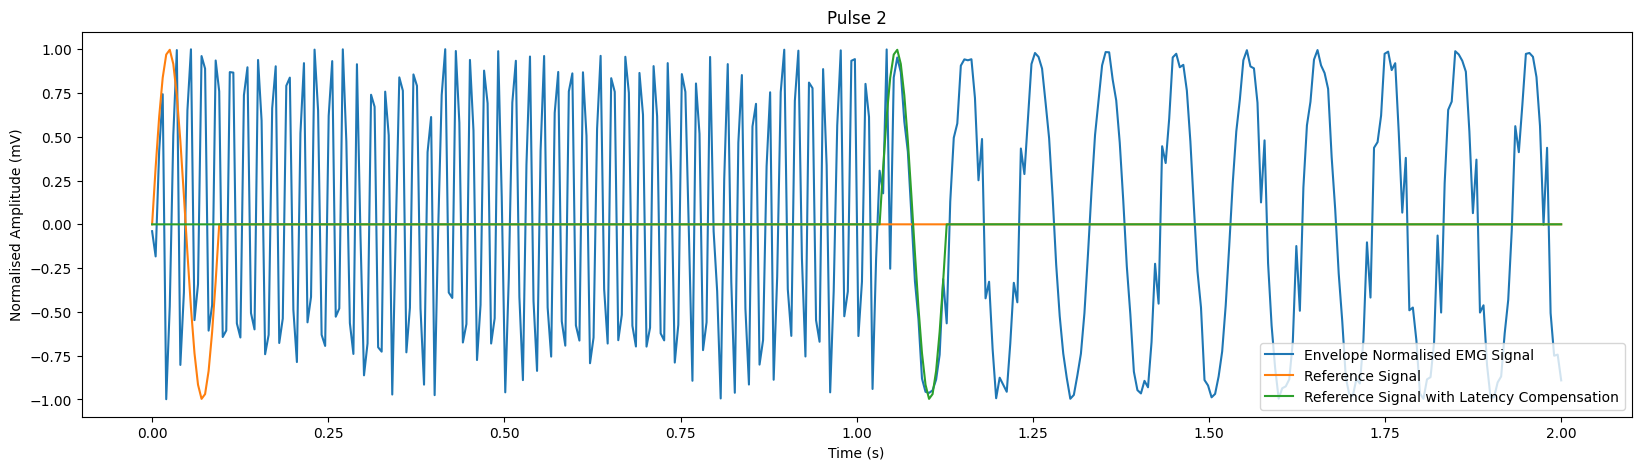

First correlation peak between EMG and generated single period: 207


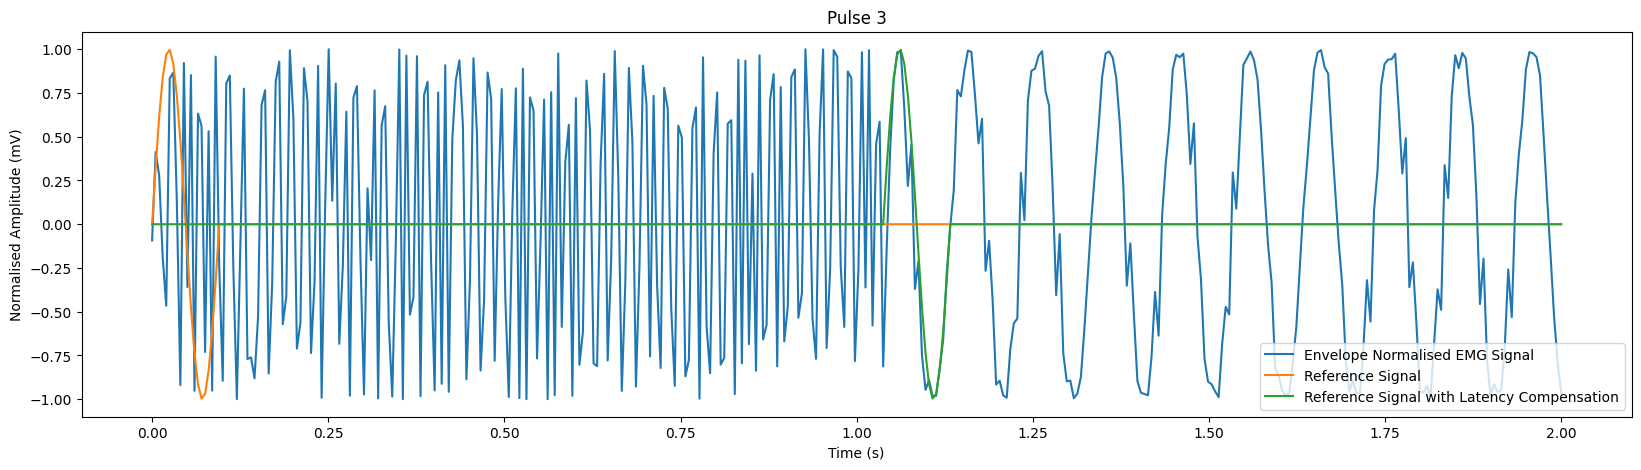

First correlation peak between EMG and generated single period: 207


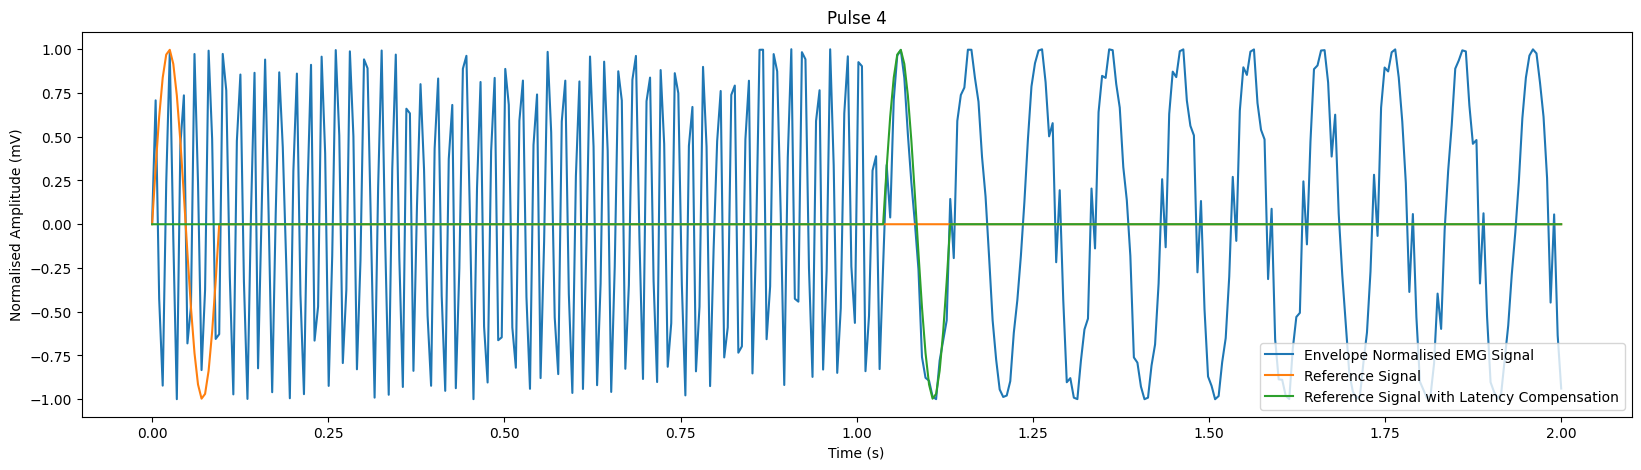

First correlation peak between EMG and generated single period: 206


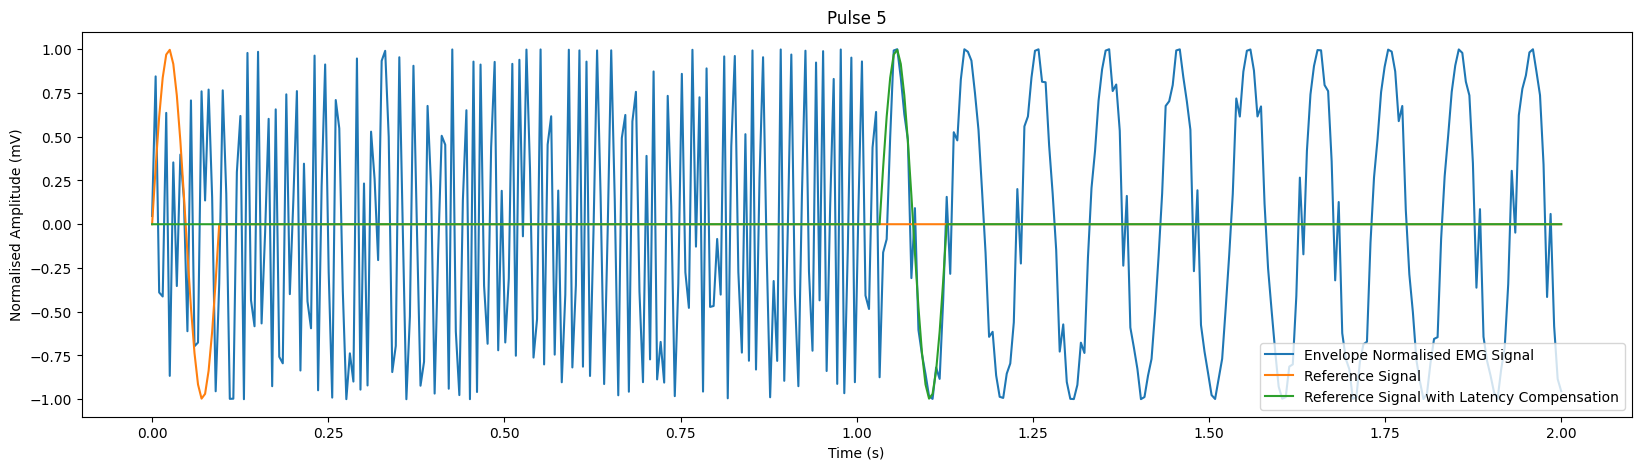

First correlation peak between EMG and generated single period: 207


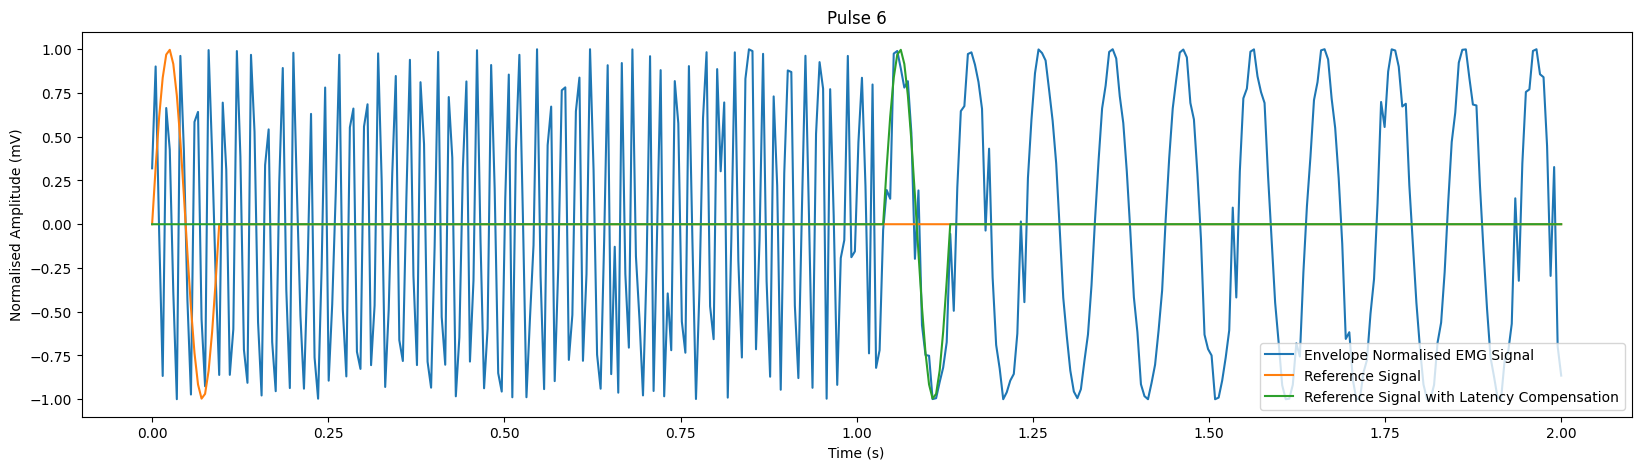

First correlation peak between EMG and generated single period: 207


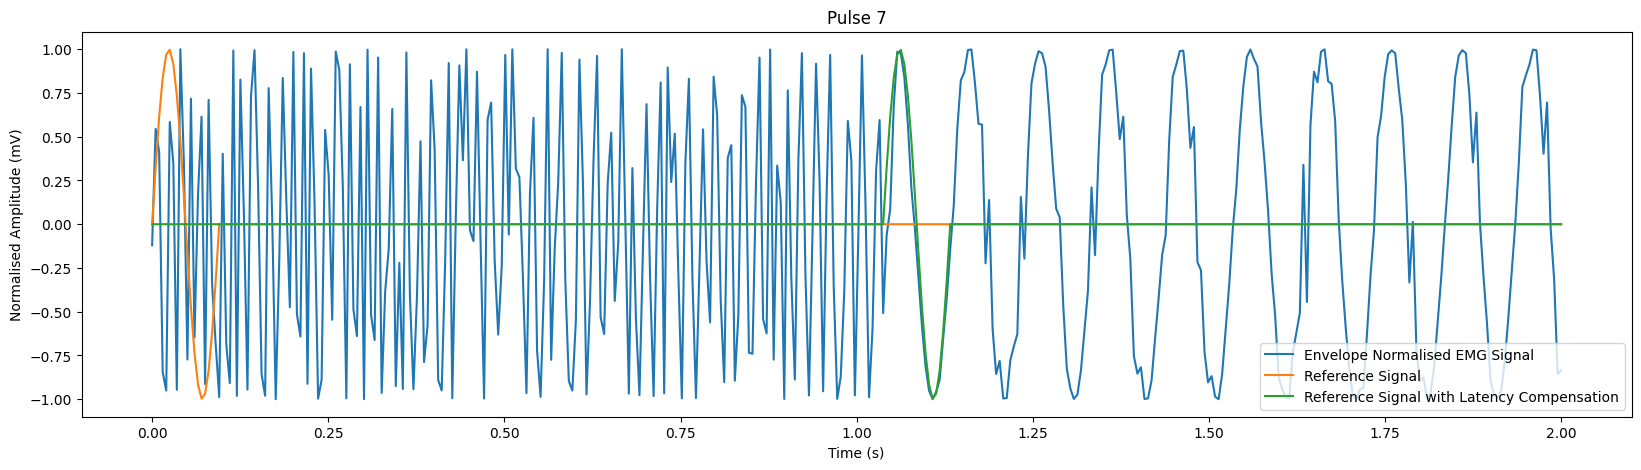

First correlation peak between EMG and generated single period: 207


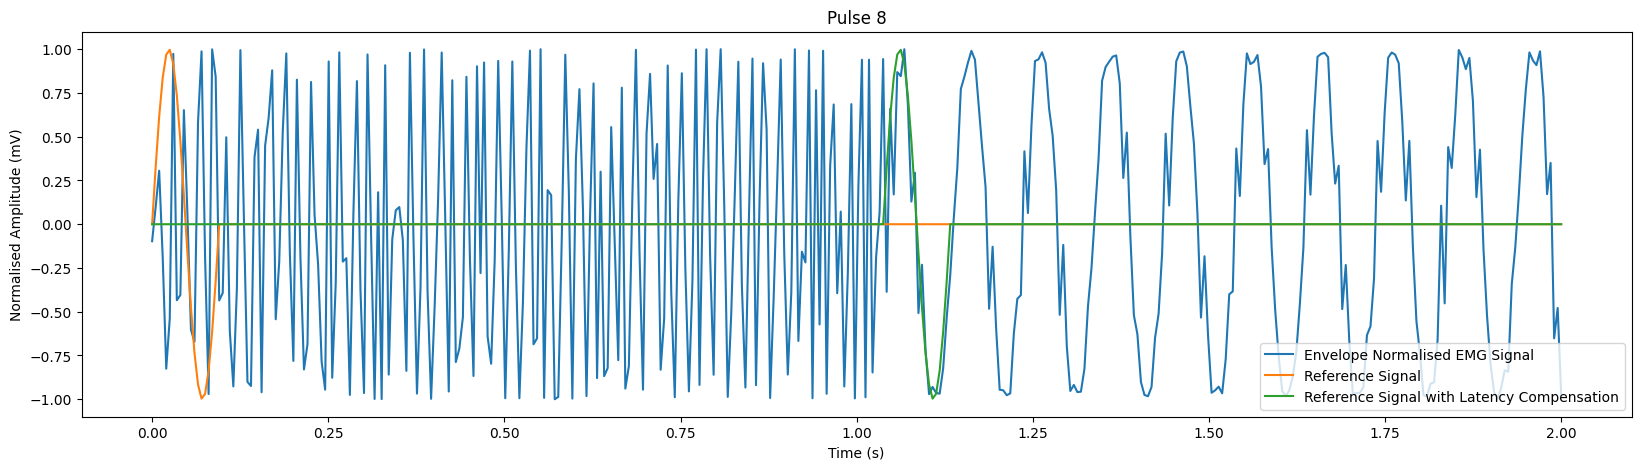

First correlation peak between EMG and generated single period: 208


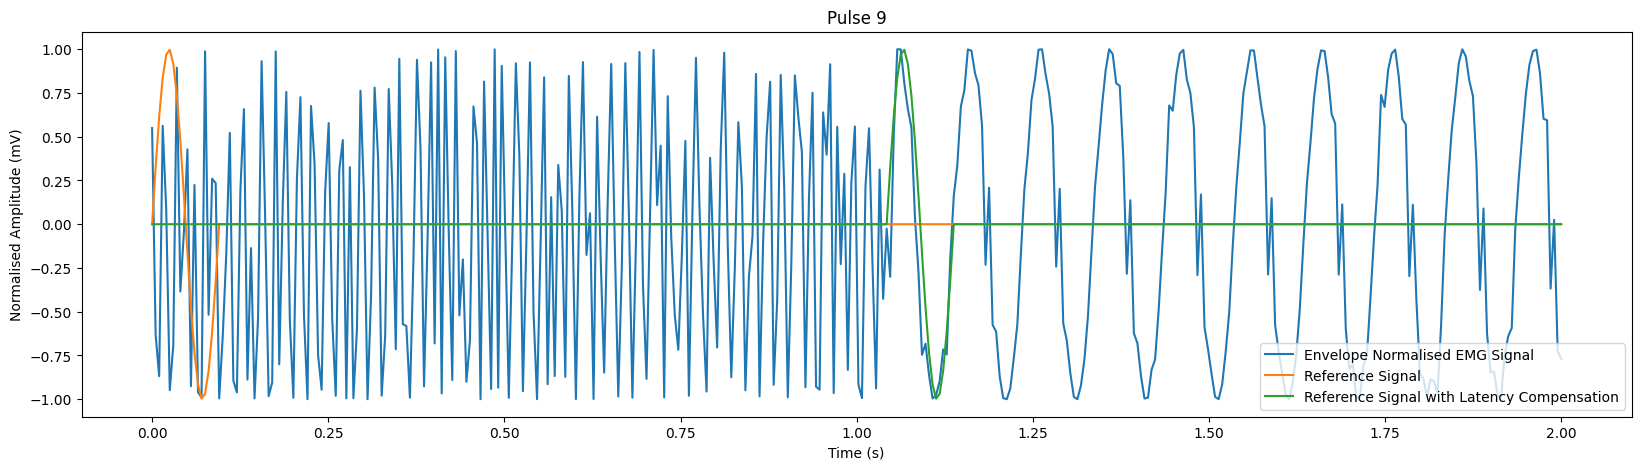

First correlation peak between EMG and generated single period: 207
First correlation peak between EMG and generated single period: 208
First correlation peak between EMG and generated single period: 205
First correlation peak between EMG and generated single period: 208
First correlation peak between EMG and generated single period: 206
First correlation peak between EMG and generated single period: 206
First correlation peak between EMG and generated single period: 206
First correlation peak between EMG and generated single period: 207
First correlation peak between EMG and generated single period: 206
First correlation peak between EMG and generated single period: 208
First correlation peak between EMG and generated single period: 207
First correlation peak between EMG and generated single period: 208
First correlation peak between EMG and generated single period: 206
First correlation peak between EMG and generated single period: 208
First correlation peak between EMG and generated

In [7]:
# generate sine of single period as reference

t = np.linspace(0, 1, int(myo_sr*0.1))
sine = -sine_wave(t=t, A=1, f=1, phase=0*np.pi, offset=0)
sine = -np.concatenate((sine, np.zeros(int(myo_sr*1.9))))

myo_correlation_lags_samples = np.zeros(waveform_start_counts)

for key, val in waveform_dict.items():

    # normalise signal by amplitude envelope to improve correlation results
    env = amplitude_envelope(val)
    sig  = val/env

    # calculate cross-correlation between EMG signal and reference signal
    lags, corr = correlation(sig, sine)

    # get first local maximum of correlation
    first_lag = first_maximum_lag(corr, lags)
    myo_correlation_lags_samples[int(key)] = first_lag

    # apply latency compensation to EMG signal for display
    latency_compensated = np.roll(sine, first_maximum_lag(corr, lags))
    print(f"First correlation peak between EMG and generated single period: {first_lag}")

    if int(key) < no_to_display:
    #if first_lag < 0:

        plt.figure(figsize=(20, 5))
        plt.title(f"Pulse {key}")
        plt.xlabel("Time (s)")
        plt.ylabel("Normalised Amplitude (mV)")
        plt.plot(x, sig, label="Envelope Normalised EMG Signal")
        plt.plot(x, sine, label="Reference Signal")
        plt.plot(x, latency_compensated, label="Reference Signal with Latency Compensation")
        plt.legend(loc="lower right")
        plt.show()

myo_correlation_lags_seconds = myo_correlation_lags_samples/myo_sr
myo_correlation_lags_seconds -= 1

In [8]:
print(f"Mean Latency for Myo (s): {np.mean(myo_correlation_lags_seconds)}")
print(f"Median Latency for Myo (s): {np.median(myo_correlation_lags_seconds)}")
print(f"Min Latency for Myo (s): {np.min(myo_correlation_lags_seconds)}")
print(f"Max Latency for Myo (s): {np.max(myo_correlation_lags_seconds)}")
print(f"SD Latency for Myo (s): {np.std(myo_correlation_lags_seconds)}")
print(f"IQR Latency for Myo (s): {np.percentile(myo_correlation_lags_seconds, 75)-np.percentile(myo_correlation_lags_seconds, 25)}")

Mean Latency for Myo (s): 0.02599999999999998
Median Latency for Myo (s): 0.03499999999999992
Min Latency for Myo (s): -0.985
Max Latency for Myo (s): 0.24
SD Latency for Myo (s): 0.09765858897198956
IQR Latency for Myo (s): 0.010000000000000009


# SiFiBand

In [24]:
#fp = "../../data_collection/logs/2025_02_28_11_47_21_SiFiBand_Latency/"
fp = "../../data_collection/logs/2025_03_11_23_33_07_SiFi_EMG_Latency/"

sifi_path = "sifiband/emg/emg.csv"
event_path = "event_log/event_log.csv"

sifi_df = pd.read_csv(os.path.join(fp, sifi_path))
event_df = pd.read_csv(os.path.join(fp, event_path))

sifi_sr = 2000

In [25]:
waveform_start_counts = 0

for event in event_df["Event"]:
    if "Waveform Pulse Start" in event:
        waveform_start_counts += 1

print(f"{waveform_start_counts} waveform pulses found")

500 waveform pulses found


In [26]:
waveform_dict = {}
durations = np.zeros(waveform_start_counts)

for i in range(waveform_start_counts):

    # get start time for pulse
    start_time = event_df.loc[event_df["Event"] == f"Waveform Pulse Start {str(i).zfill(5)}", "Event Time"].values[0]
    end_time = event_df.loc[event_df["Event"] == f"Waveform Pulse End {str(i).zfill(5)}", "Event Time"].values[0]
    durations[i] = end_time-start_time

    # crop to pulse time plus gap to ensure whole pulse in signal and take first 2 seconds
    cropped = crop_dataframes(sifi_df, start_time, end_time+2)
    cropped = cropped["emg0"].to_numpy()[:int(sifi_sr*2)]
    cropped = cropped-np.mean(cropped)
    waveform_dict[str(i)] = cropped

print(f"Mean Pulse Duration {np.mean(durations)}")

Mean Pulse Duration 0.9999891352653504


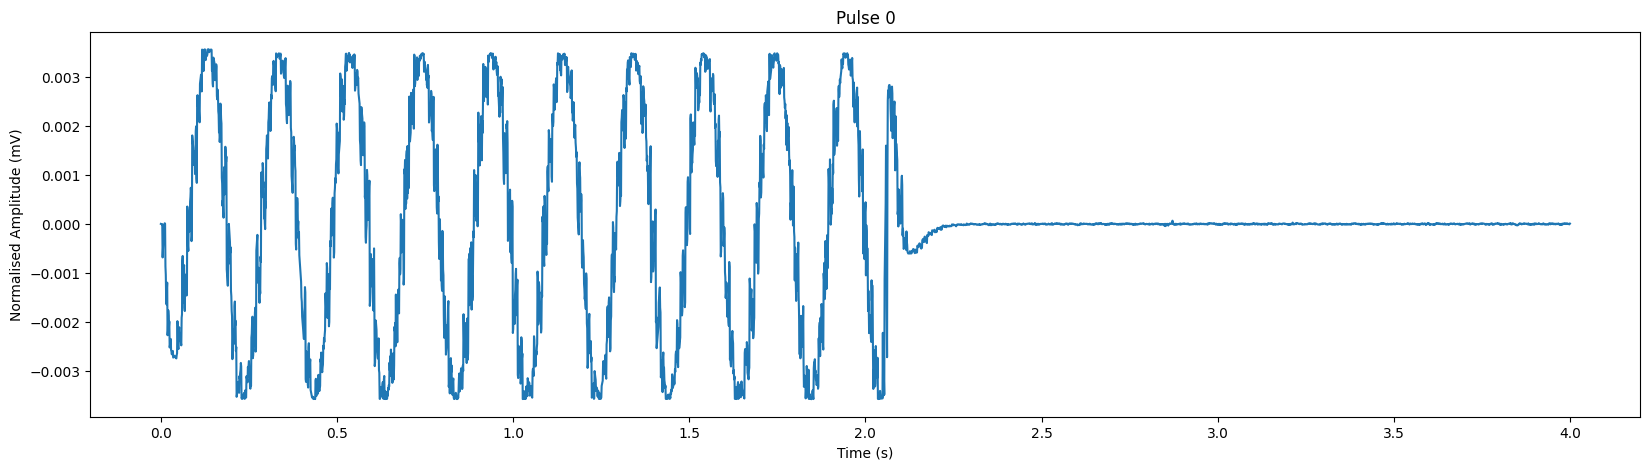

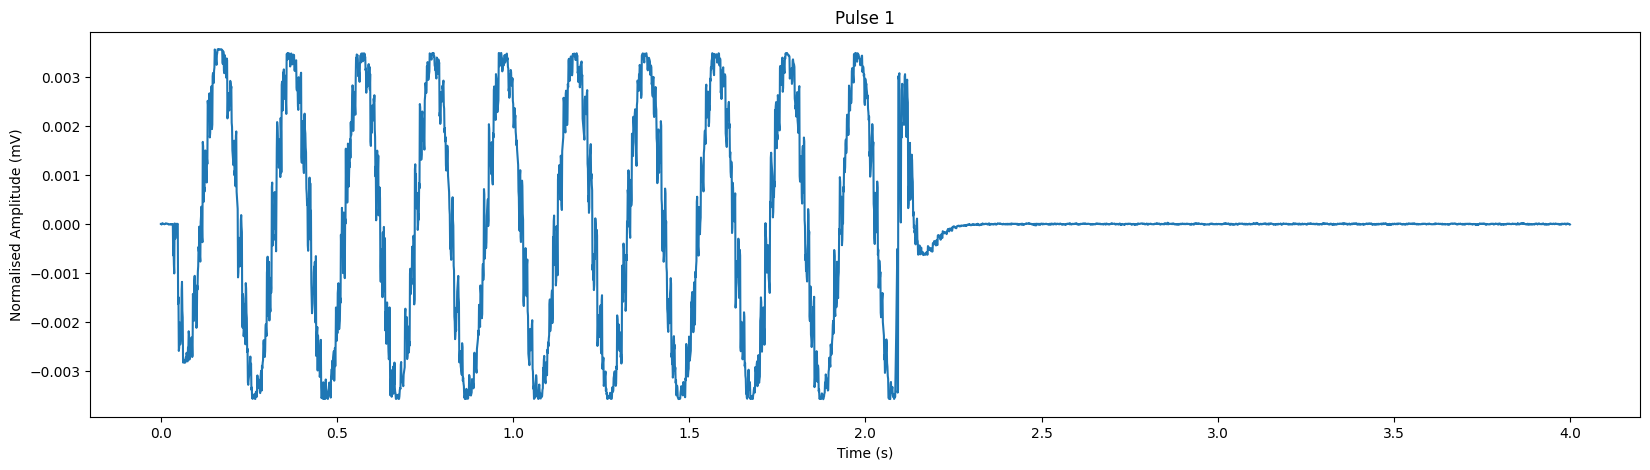

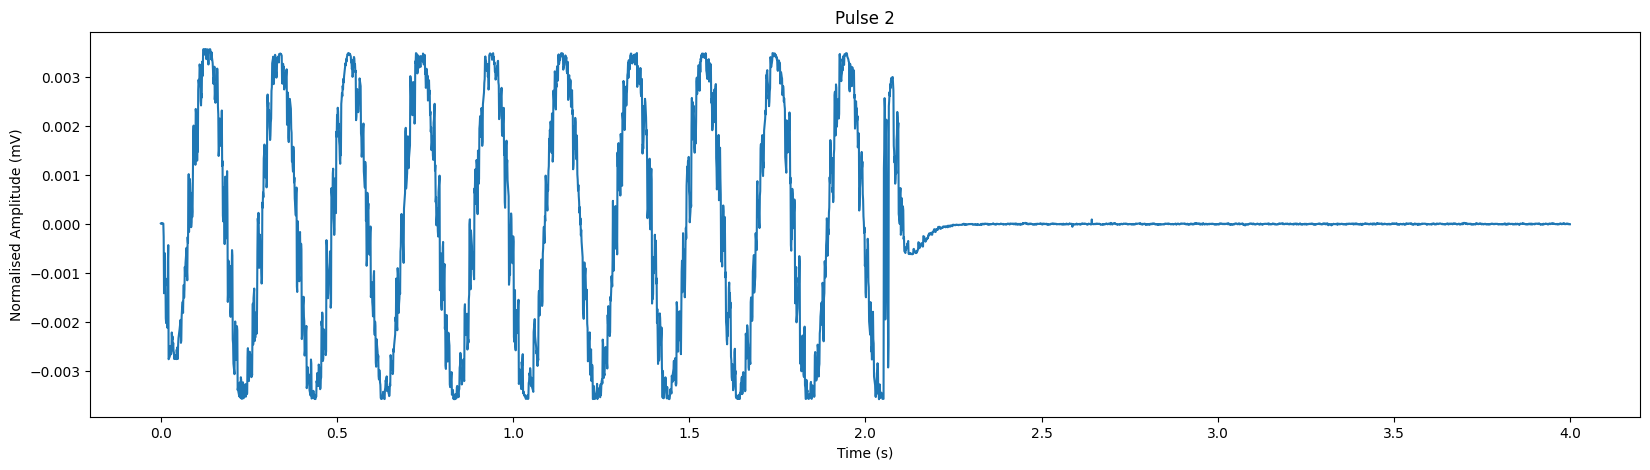

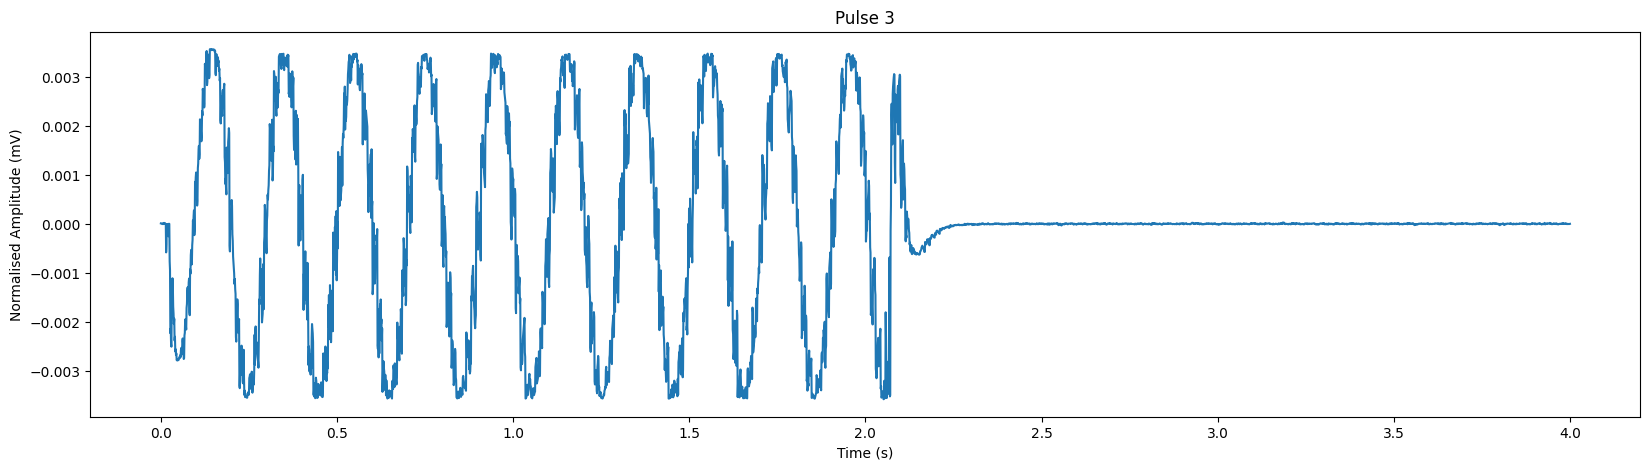

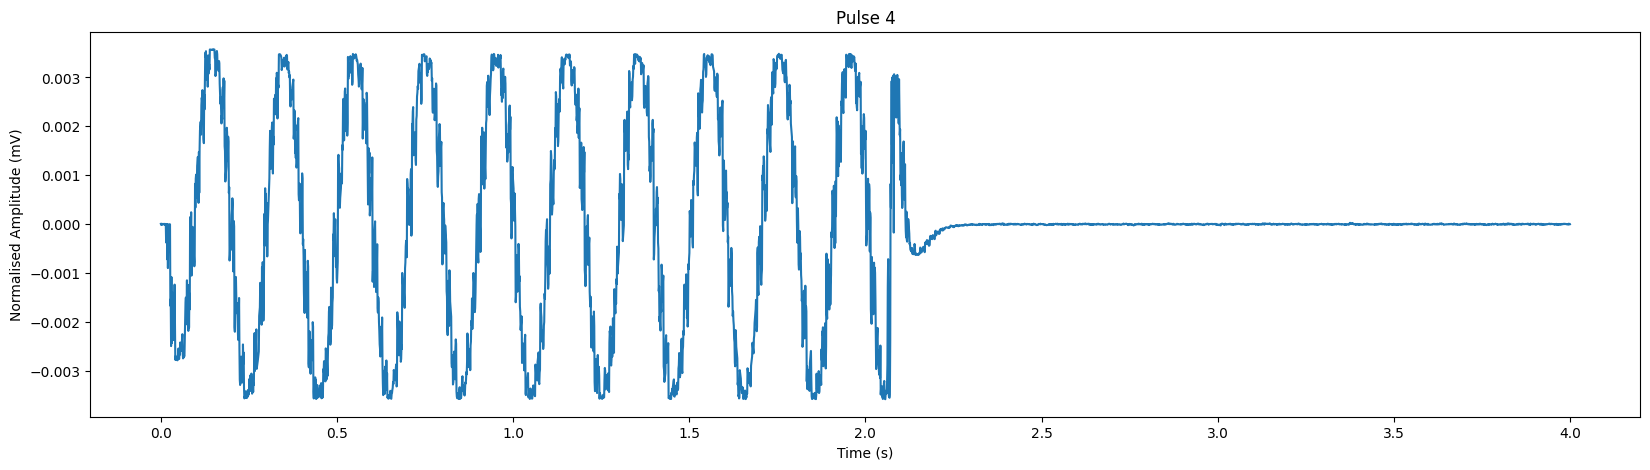

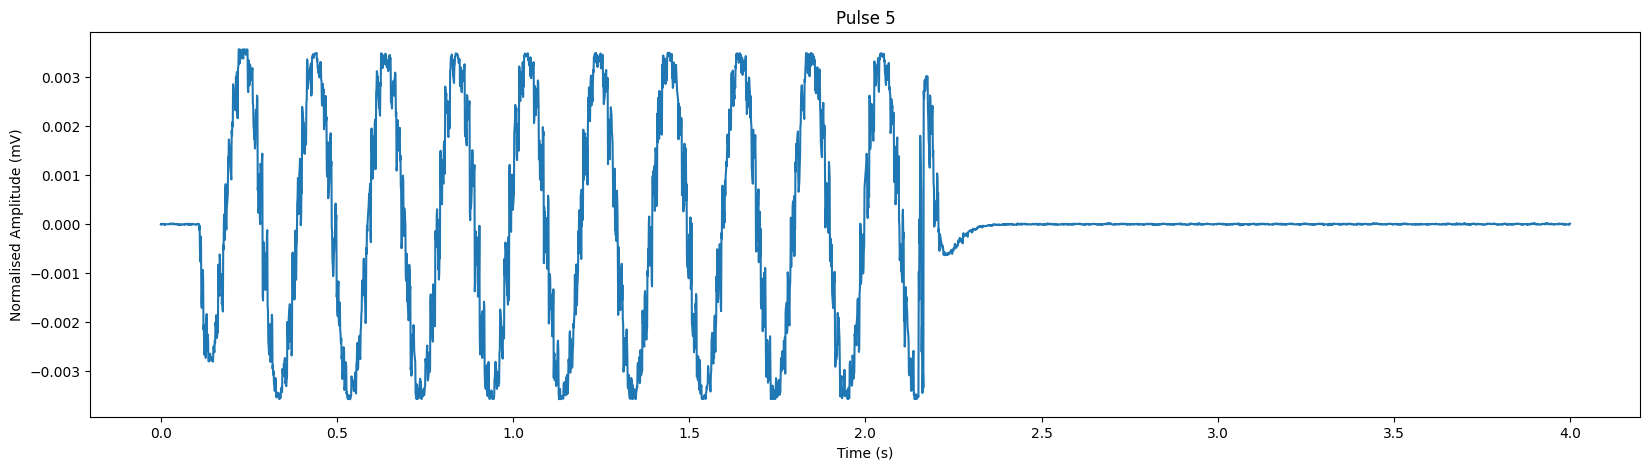

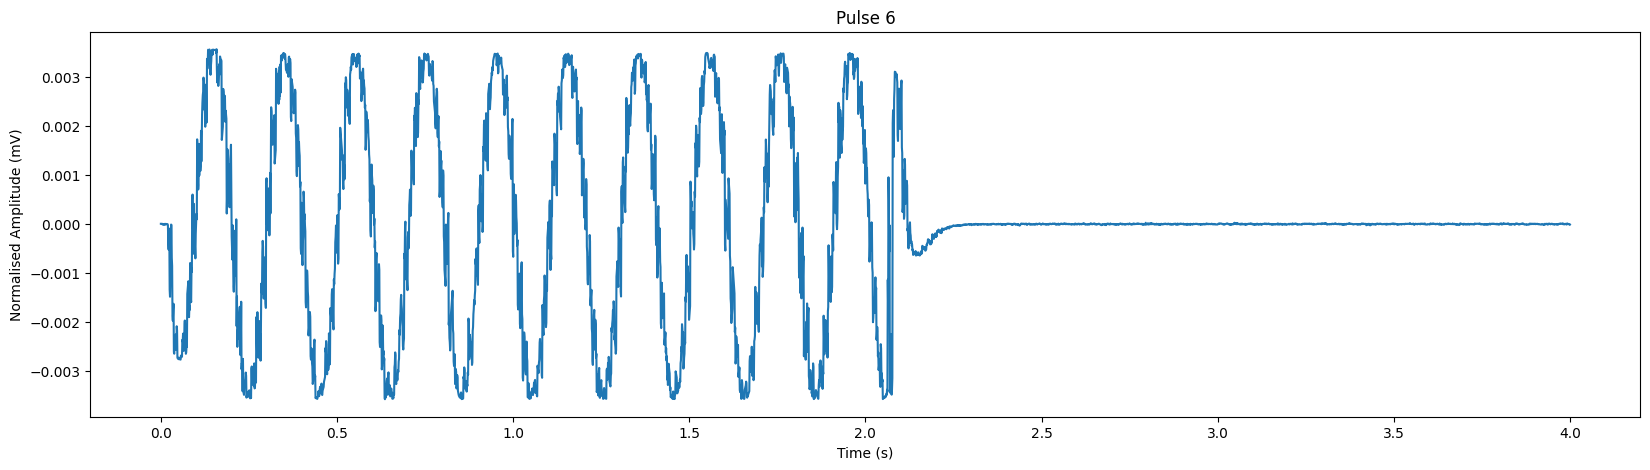

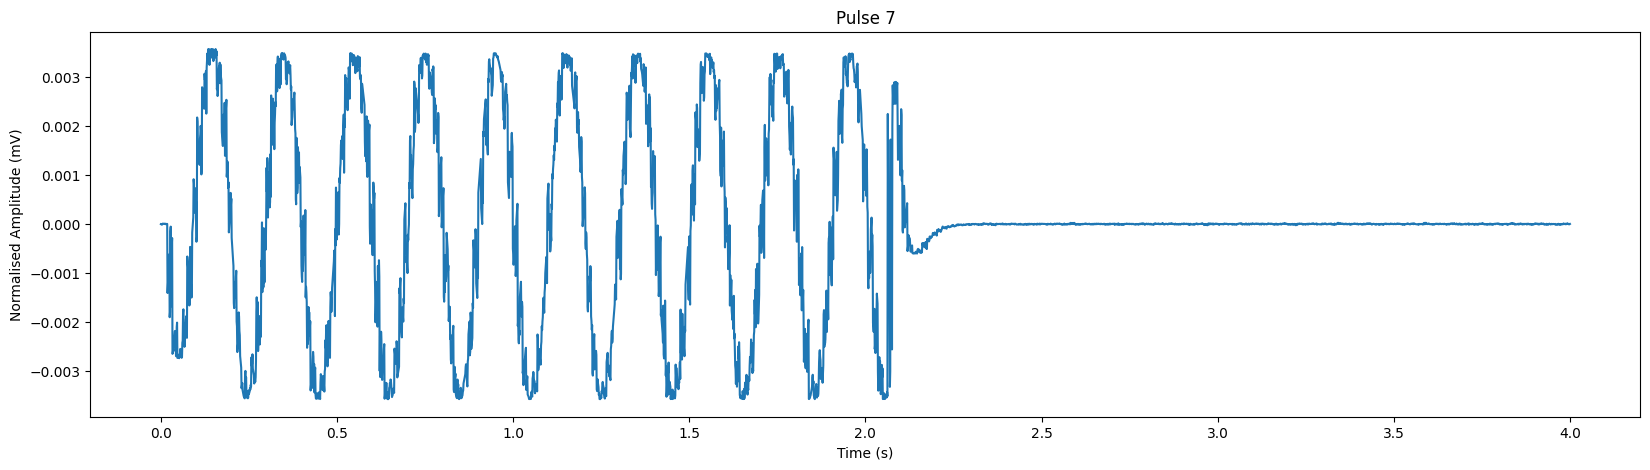

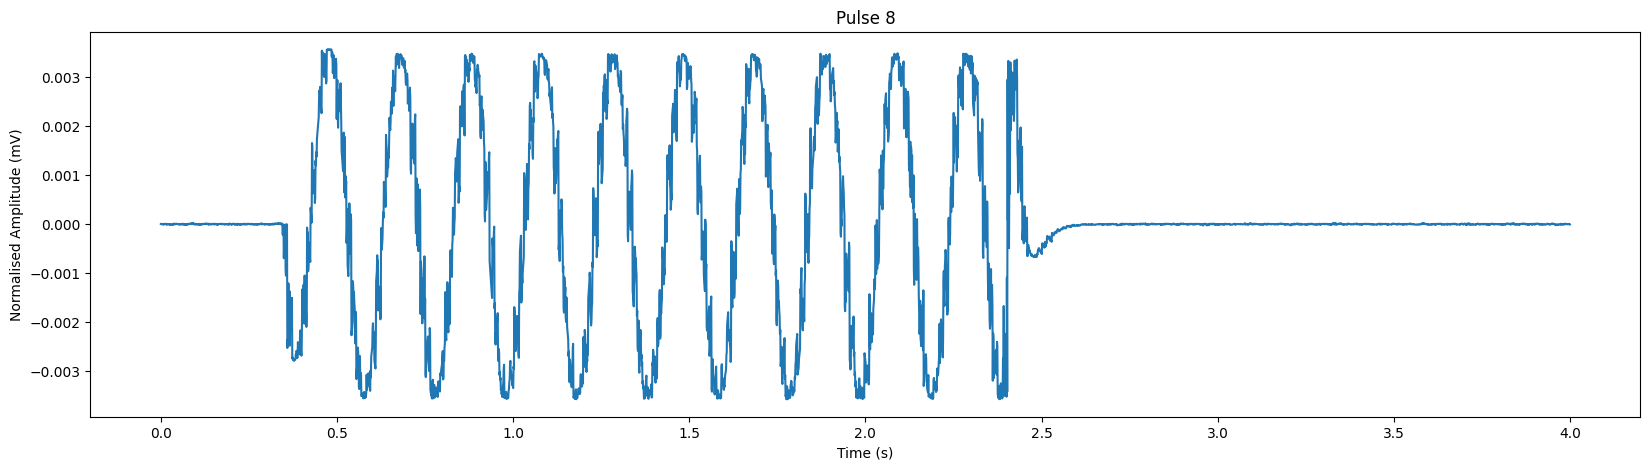

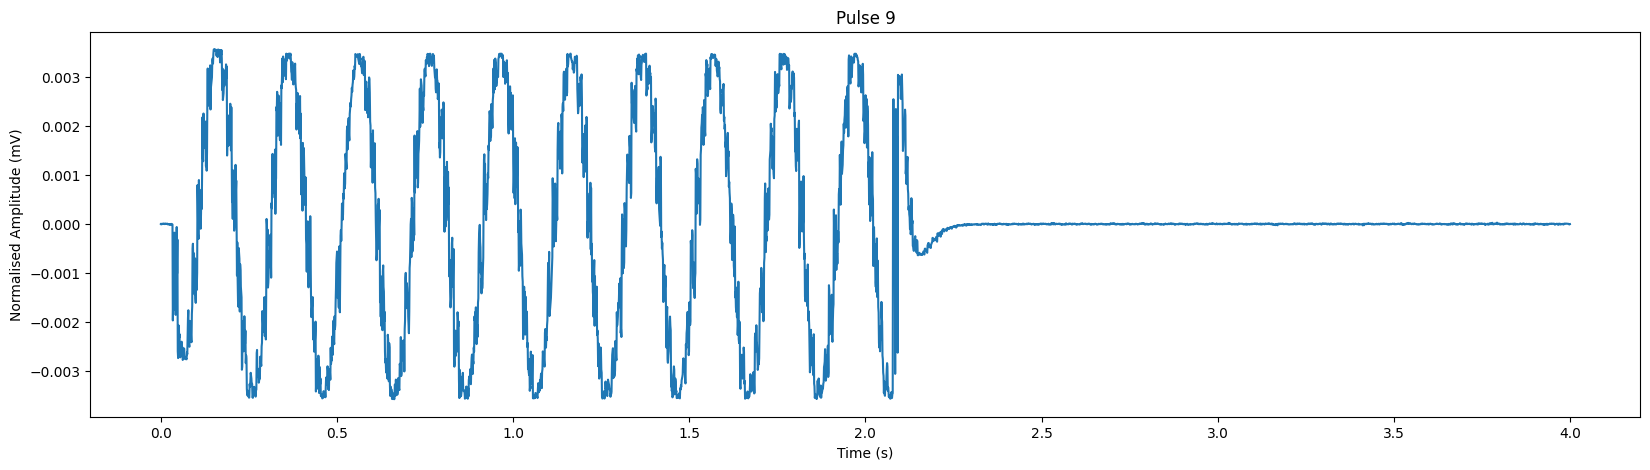

In [27]:
no_to_display = 10

for i in range(no_to_display):

    sig = waveform_dict[str(i)]
    x = np.linspace(0, 4, len(sig))

    plt.figure(figsize=(20, 5))
    plt.title(f"Pulse {i}")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalised Amplitude (mV)")
    plt.plot(x, sig)
    plt.show()

First correlation peak between EMG and generated single period: -13


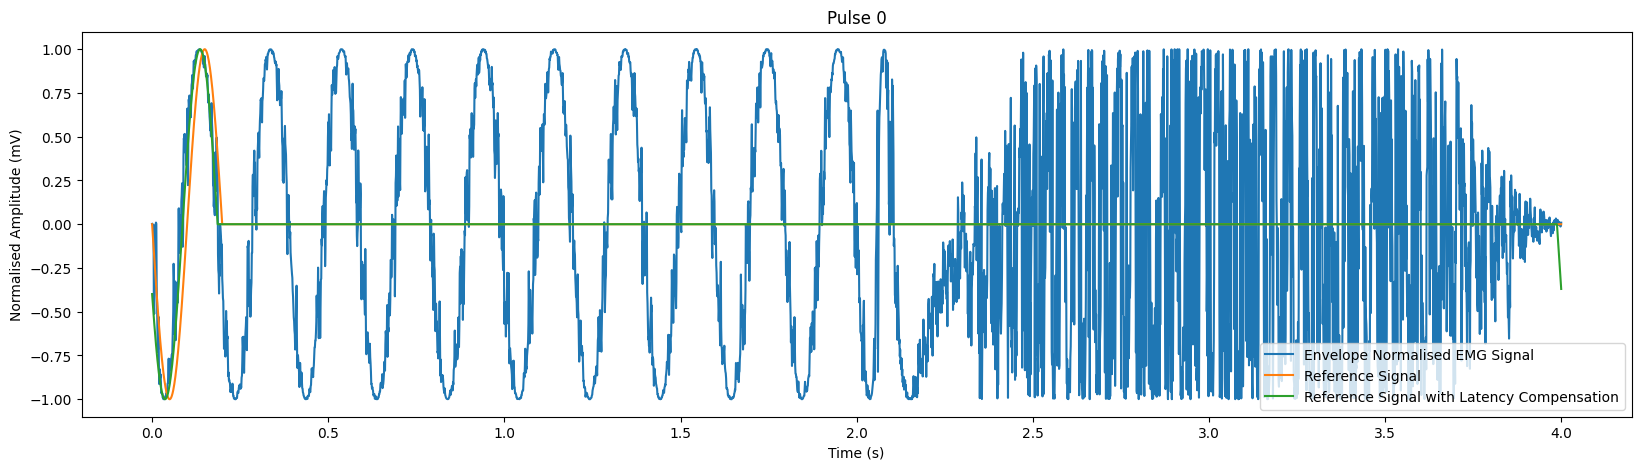

First correlation peak between EMG and generated single period: 21


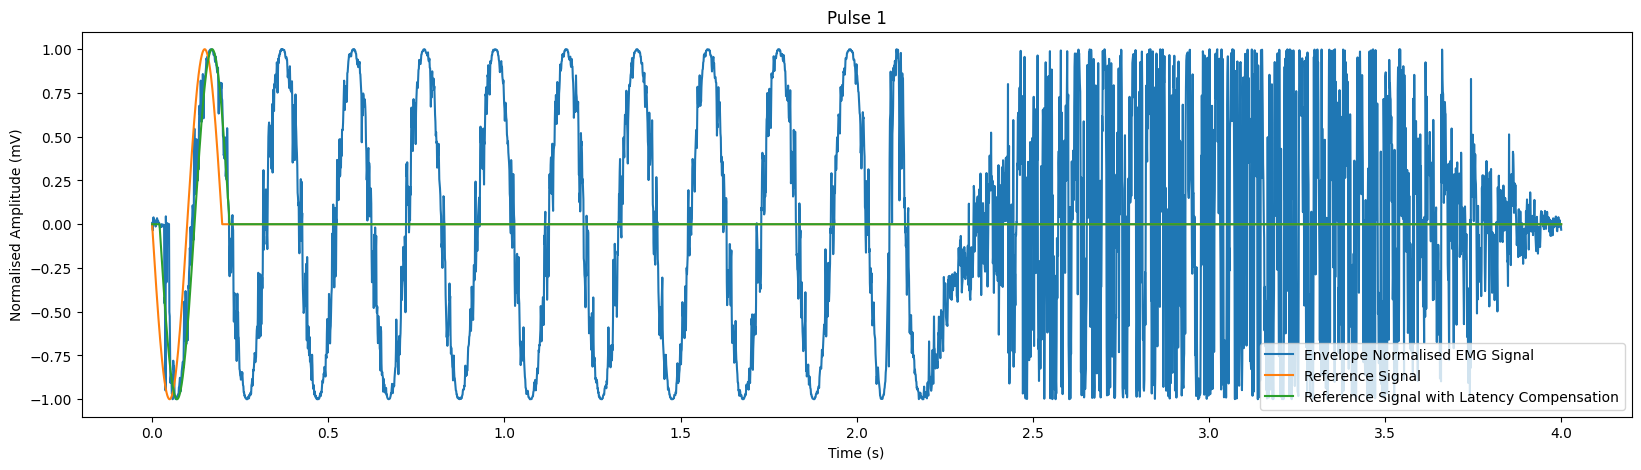

First correlation peak between EMG and generated single period: -15


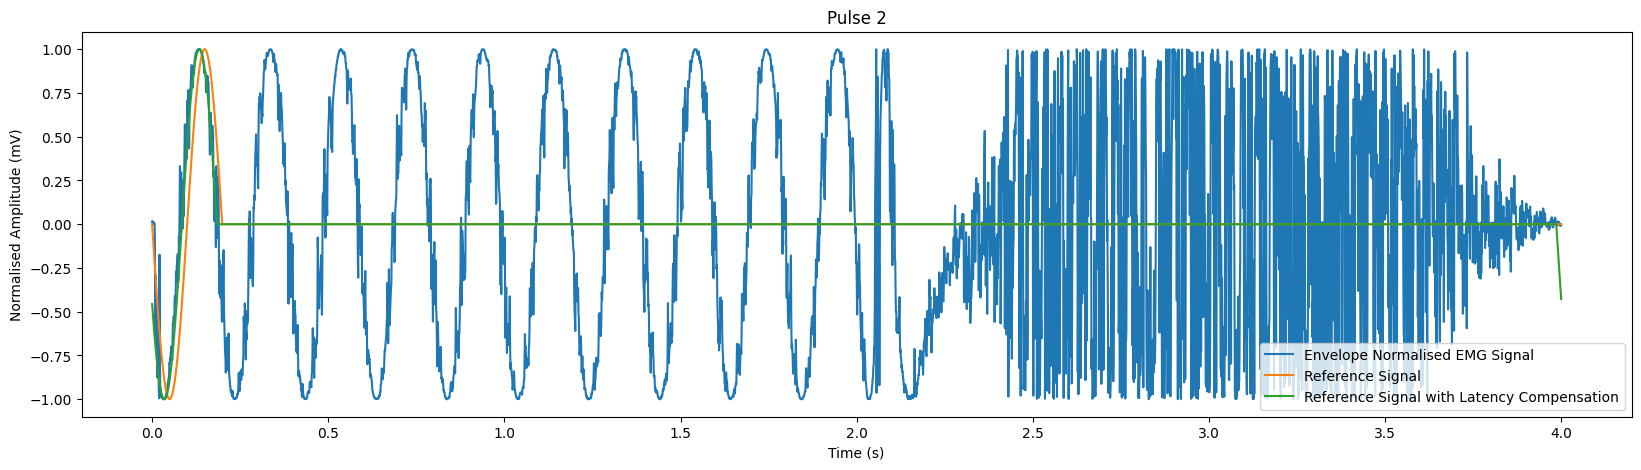

First correlation peak between EMG and generated single period: 0


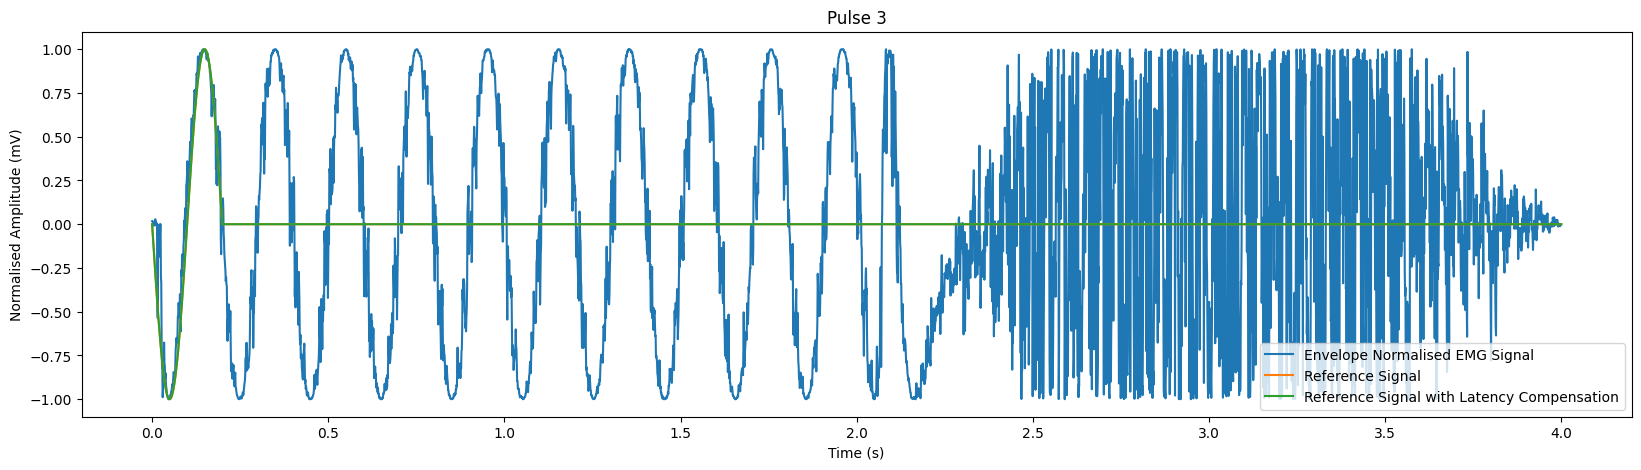

First correlation peak between EMG and generated single period: 0


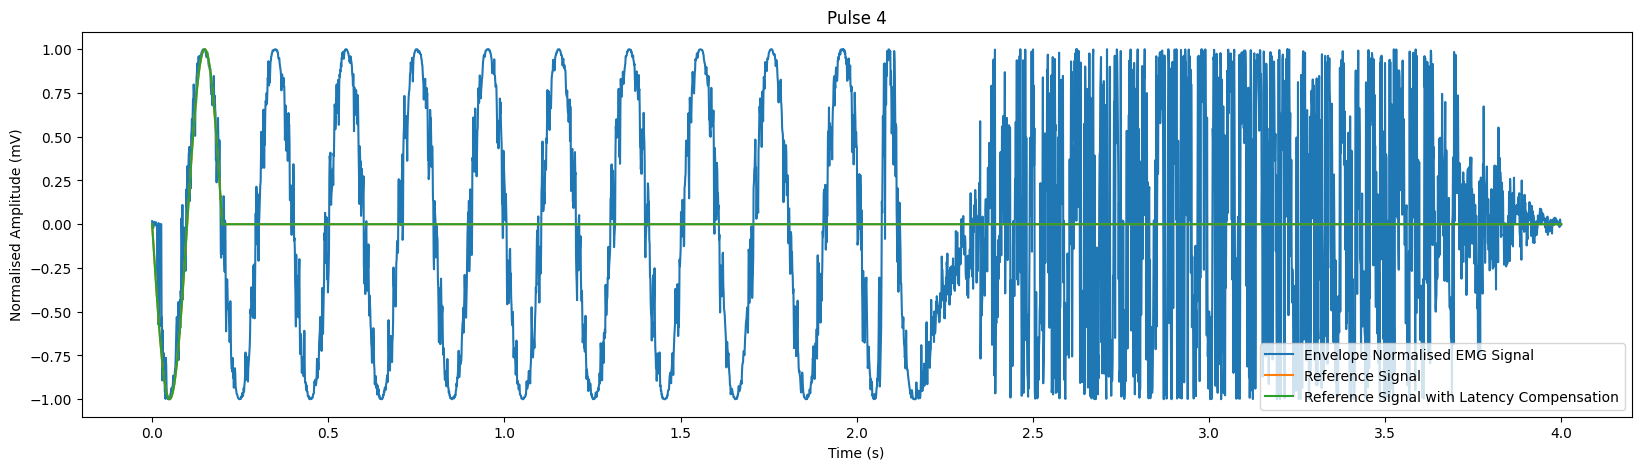

First correlation peak between EMG and generated single period: 89


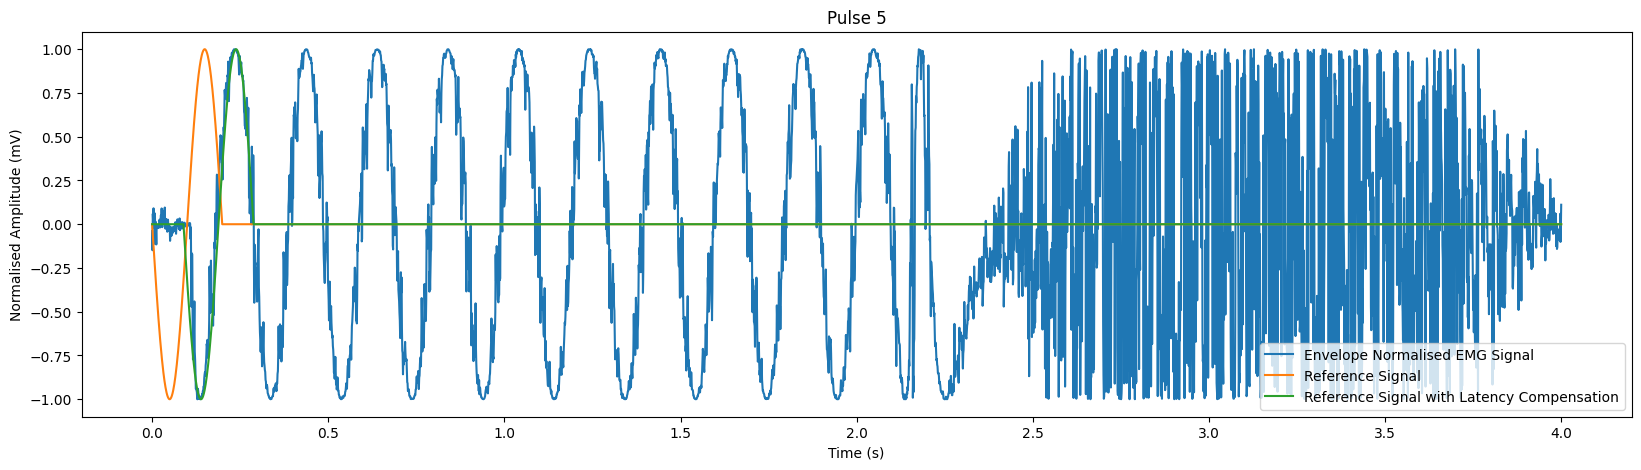

First correlation peak between EMG and generated single period: 2


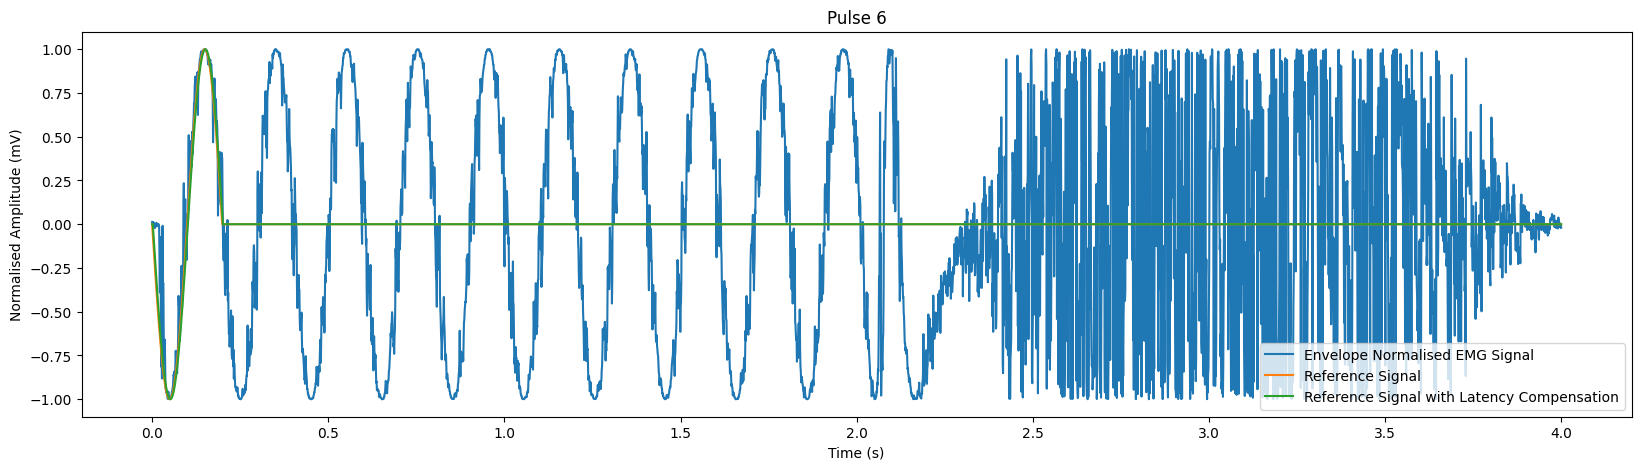

First correlation peak between EMG and generated single period: -2


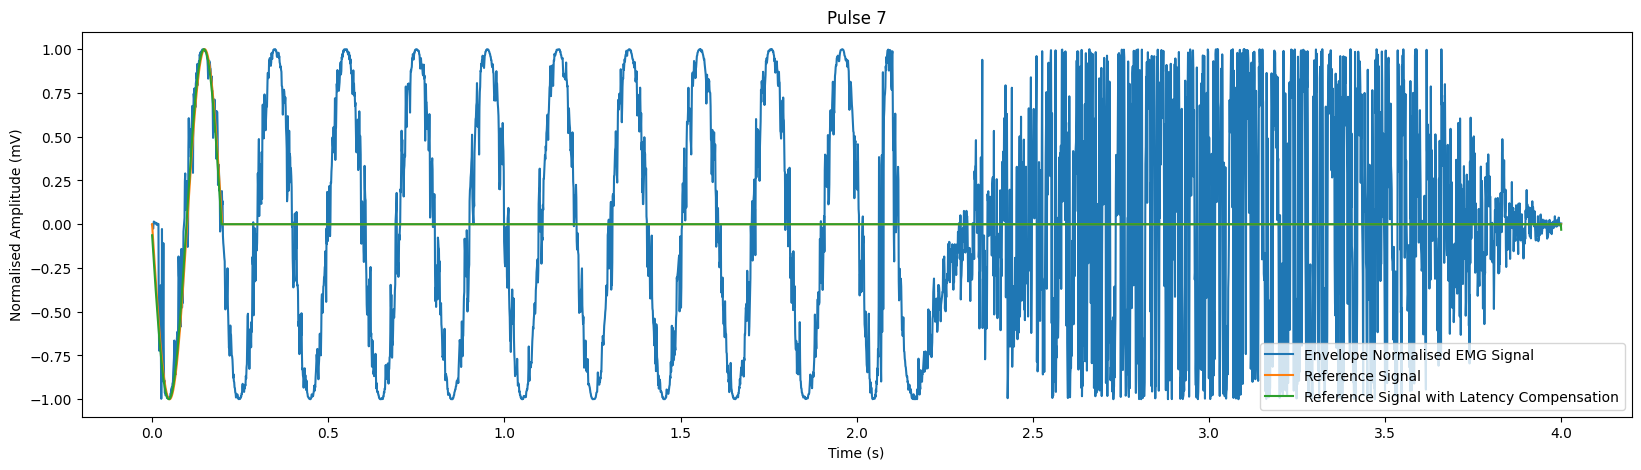

First correlation peak between EMG and generated single period: 331


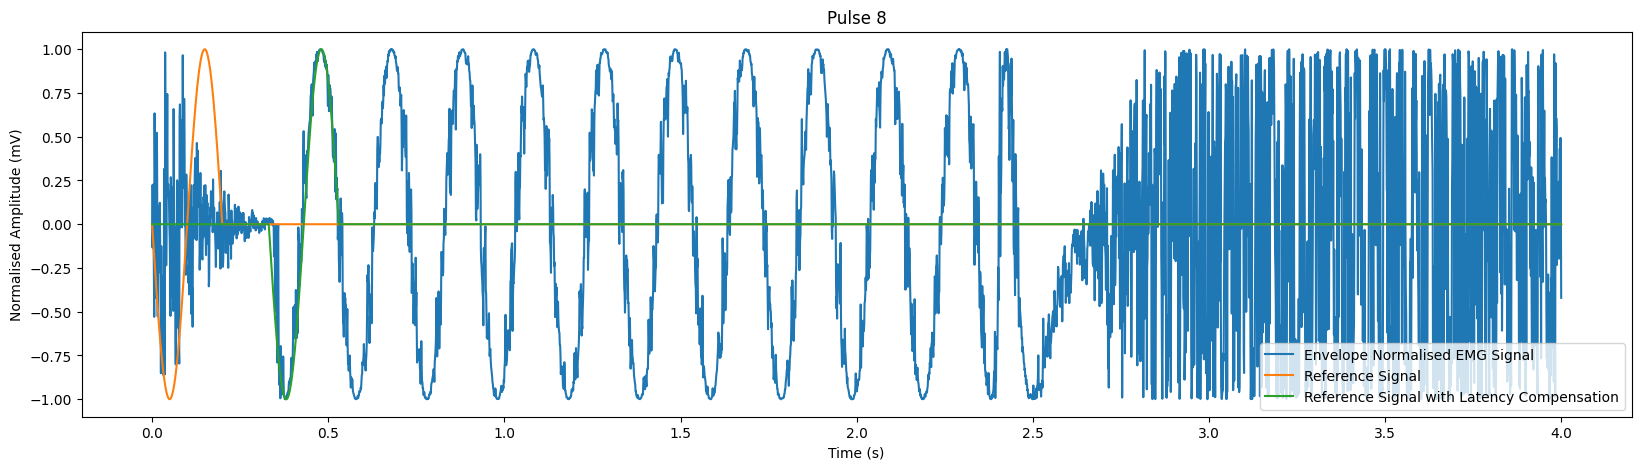

First correlation peak between EMG and generated single period: 13


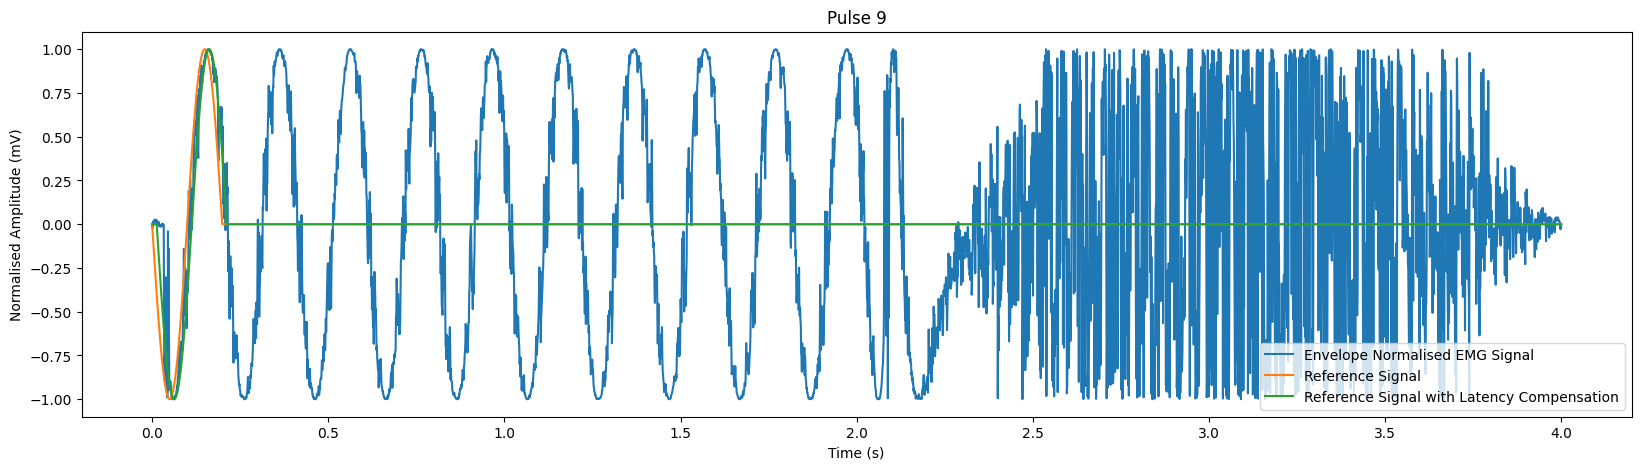

First correlation peak between EMG and generated single period: -10
First correlation peak between EMG and generated single period: -24
First correlation peak between EMG and generated single period: 31
First correlation peak between EMG and generated single period: 11
First correlation peak between EMG and generated single period: 5
First correlation peak between EMG and generated single period: 42
First correlation peak between EMG and generated single period: 134
First correlation peak between EMG and generated single period: 436
First correlation peak between EMG and generated single period: 59
First correlation peak between EMG and generated single period: -5
First correlation peak between EMG and generated single period: -11
First correlation peak between EMG and generated single period: -10
First correlation peak between EMG and generated single period: -19
First correlation peak between EMG and generated single period: 5
First correlation peak between EMG and generated single p

In [28]:
# generate sine of single period as reference

t = np.linspace(0, 1, int(sifi_sr*0.1))
sine = -sine_wave(t=t, A=1, f=1, phase=0*np.pi, offset=0)
sine = np.concatenate((sine, np.zeros(int(sifi_sr*1.9))))

sifi_correlation_lags_samples = np.zeros(waveform_start_counts)

for key, val in waveform_dict.items():

    # normalise signal by amplitude envelope to improve correlation results
    env = amplitude_envelope(val)
    sig  = val/env

    # calculate cross-correlation between EMG signal and reference signal
    lags, corr = correlation(sig, sine)

    # get first local maximum of correlation
    first_lag = first_maximum_lag(corr, lags)
    sifi_correlation_lags_samples[int(key)] = first_lag

    # apply latency compensation to EMG signal for display
    latency_compensated = np.roll(sine, first_maximum_lag(corr, lags))
    print(f"First correlation peak between EMG and generated single period: {first_lag}")

    if int(key) < no_to_display:
    #if first_lag < 0:

        plt.figure(figsize=(20, 5))
        plt.title(f"Pulse {key}")
        plt.xlabel("Time (s)")
        plt.ylabel("Normalised Amplitude (mV)")
        plt.plot(x, sig, label="Envelope Normalised EMG Signal")
        plt.plot(x, sine, label="Reference Signal")
        plt.plot(x, latency_compensated, label="Reference Signal with Latency Compensation")
        plt.legend(loc="lower right")
        plt.show()

sifi_correlation_lags_seconds = sifi_correlation_lags_samples/sifi_sr

In [29]:
print(f"Mean Latency for SiFiBand (s): {np.mean(sifi_correlation_lags_seconds)}")
print(f"Median Latency for SiFiBand (s): {np.median(sifi_correlation_lags_seconds)}")
print(f"Min Latency for SiFiBand (s): {np.min(sifi_correlation_lags_seconds)}")
print(f"Max Latency for SiFiBand (s): {np.max(sifi_correlation_lags_seconds)}")
print(f"SD Latency for SiFiBand (s): {np.std(sifi_correlation_lags_seconds)}")
print(f"IQR Latency for SiFiBand (s): {np.percentile(sifi_correlation_lags_seconds, 75)-np.percentile(sifi_correlation_lags_seconds, 25)}")

Mean Latency for SiFiBand (s): 0.009044999999999997
Median Latency for SiFiBand (s): 0.0005
Min Latency for SiFiBand (s): -0.0175
Max Latency for SiFiBand (s): 0.218
SD Latency for SiFiBand (s): 0.030655056271355955
IQR Latency for SiFiBand (s): 0.016


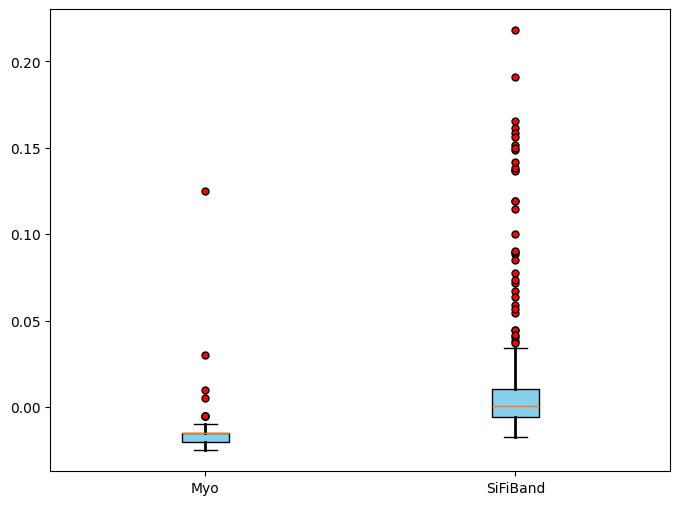

In [30]:
plt.figure(figsize=(8, 6))

plt.boxplot([myo_correlation_lags_seconds, sifi_correlation_lags_seconds
             
             ], patch_artist=True, 
            boxprops=dict(facecolor='skyblue', color='black'),
            whiskerprops=dict(color='black', linewidth=2),
            capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=5))

plt.xticks([1, 2], ['Myo', 'SiFiBand'])

plt.show()